In [7]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from torch.autograd import Variable
import argparse

plt.ion()   # interactive mode

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation

data_dir = '../ssl_data_96/supervised'
train_dir = 'train'
val_dir = 'val'

data_transforms = {
    train_dir: transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    val_dir: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]),
}


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in [train_dir, val_dir]}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in [train_dir, val_dir]}
dataset_sizes = {x: len(image_datasets[x]) for x in [train_dir, val_dir]}
class_names = image_datasets[train_dir].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

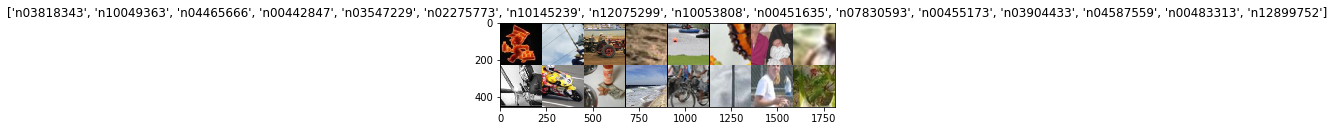

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders[train_dir]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
inputs

tensor([[[[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          ...,
          [0.0157, 0.0157, 0.0157,  ..., 0.0039, 0.0039, 0.0039],
          [0.0118, 0.0118, 0.0157,  ..., 0.0039, 0.0000, 0.0000],
          [0.0118, 0.0118, 0.0157,  ..., 0.0039, 0.0000, 0.0000]],

         [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          ...,
          [0.0157, 0.0157, 0.0157,  ..., 0.0039, 0.0039, 0.0039],
          [0.0118, 0.0118, 0.0157,  ..., 0.0039, 0.0000, 0.0000],
          [0.0118, 0.0118, 0.0157,  ..., 0.0039, 0.0000, 0.0000]],

         [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[val_dir]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [75]:
model_conv = torchvision.models.inception_v3(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

model_conv = model_conv.to(device)

In [7]:
def getPredictionMappings(model, dataloader):
    was_training = model.training
    model.eval()
    
    resultdic = {}
    for j in range(len(class_names)):
        resultdic[j] = {}
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(len(labels)):
                predjItem = preds[j].item()
                labeljItem = labels[j].item()
                if predjItem not in resultdic[labeljItem]:
                    resultdic[labeljItem][predjItem] = 0
                resultdic[labeljItem][predjItem] += 1

    model.train(mode = was_training)
    return resultdic

In [81]:
resultDic = getPredictionMappings(model_conv, dataloaders["val"])

KeyboardInterrupt: 

In [ ]:
vggmappingDictionary = {}
for label in resultDic:
    v = resultDic[label].values()
    k = resultDic[label].keys()
    maxval = max(v)
    maxkey = k[v.index(maxval)]
    vggmappingDictionary[label] = (maxkey, (maxval/64)*100)
    
fileString = ''
for label in vggmappingDictionary:
    fileString = fileString + class_names[label] + ':' + str(vggmappingDictionary[label]) + '\n'

f = open('vgg_mapping.txt','wb+')
f.write(fileString)
f.close()

In [54]:
loader = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor()])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=False)
    image = image.unsqueeze(0)
    return image 

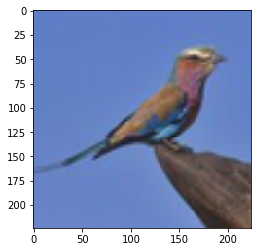

tensor([[10]])


In [77]:
single_pt_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

image = image_loader('../ssl_data_96/supervised/old_train/n00015388/n00015388_1995.JPEG')
image.to(device)
imshow(image[0])

was_training = model_conv.training
model_conv.eval()
with torch.no_grad():
    outp = model_conv(image)
    pred_top_1 = torch.topk(outp, k=1, dim=1)[1]
    print(pred_top_1)
    model_conv.train(mode = was_training)